# Sentiment analysis and topic modeling for social media using unsupervised learning


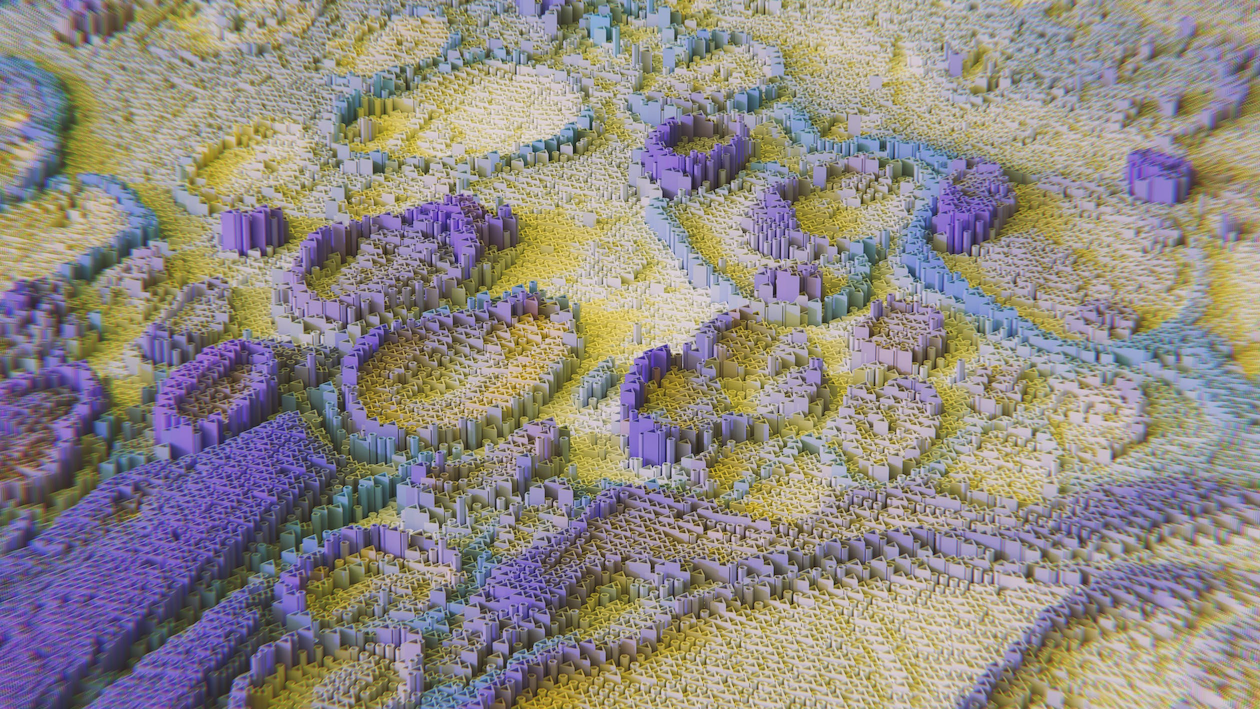

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

-----------------------------------------------------------------------------------------



# Introduction

## Content

In today's data-driven world, understanding and harnessing the power of social media data is crucial for any organization, especially in the context of financial supervision. This notebook aims to take you beyond the traditional complaint resolution process by introducing you to the advanced techniques of trend analysis, sentiment analysis, and topic modeling.

By utilizing natural language processing (NLP) and dimensionality reduction techniques such as Latent Dirichlet Allocation (LDA), we will explore how to mine historical social media data to identify clusters of activity that may reveal underlying trends.

Through this journey, you will not only learn how to apply cutting-edge clustering algorithms but also how to interpret and effectively communicate your findings, enabling you to support more informed and proactive supervisory actions. So, let's dive into the world of social media data analysis and uncover insights that can drive meaningful change in financial supervision.

## Resources and Acknowledgements

Some aspects of the code below were adapted from [Topic Model Introduction](ttps://github.com/kldarek/skok/blob/master/_notebooks/2021-05-27-Topic-Models-Introduction.ipynb) on github

The sentiment analysis components are inspired by the [huggingface blog](https://huggingface.co/blog/sentiment-analysis-python) on this subject.

Visualization of the LDA model and initial guidance on the LDA Mallet model were informed by [Neptune's blog](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know) on the subject.

For Lemmatization and removal of stopwords, [this blog on github](https://brittarude.github.io/blog/2021/12/10/LDA-Topic-Modeling) was important inspiration.

Social media data was drawn from [data.world](https://data.world/crowdflower/airline-twitter-sentiment), where it is published with a free public license.

## Defining our target

We will be taking a look at tweets relating to the major US airlines, collected in 2015. While airlines are clearly not typically under the purview of financial authorities, there are several reasons we work with this dataset, including:

* **Availability**. Public social media datasets that contain the body of the post are increasingly difficult to create or find available
* **Utility**. Like financial service providers, these are retail organizations that interact with their customers on social media, including service requests, promotional contests, and otherwise.

So with that in mind, our focus will be the following:
1. Read the tweets in and clean them up
2. Conduct a sentiment analysis to select only the tweets that are negative with a sufficient level of confidence
3. Conduct two classical topic modeling analyses to get a sense of what sorts of trends can be identified
4. Use the latest cutting-edge models to identify and visualize clusters that can be used to inform supervisory action.

# Preparation

## Importing libraries

In [8]:
# Clear unnecessary warnings from our outputs (remove this cell if modifying code!)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
##########################################
# General libraries and helper functions #
##########################################
import numpy as np
import pandas as pd
import urllib
import random
random.seed(1337) # for reproducibility!

In [4]:
##########################
# For sentiment analysis #
##########################
from transformers import pipeline # can take ~20sec
import pickle

In [5]:
####################################
# For classic (LDA + GSDMM) models #
####################################

# to identify parts of speech during lemmatization
import spacy

# for a list of words to remove during stopword removal
import nltk
from nltk.corpus import stopwords

# the models and helper functions
from gsdmm import MovieGroupProcess
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

# Visualize results of LDA
import pyLDAvis
import pyLDAvis.gensim

# Mallet
os.environ['MALLET_HOME'] = '/etc/mallet-2.0.8'
mallet_path = '/etc/mallet-2.0.8/bin/mallet'
import little_mallet_wrapper as lmw

In [10]:
# Clear unnecessary warnings from our outputs (remove this cell if modifying code!)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
##############################
# For advanced (BERT) models #
##############################

# For producing word embeddings
from sentence_transformers import SentenceTransformer

# For T-distributed Stochastic Neighbor Embedding (t-SNE) visualization
import sklearn.manifold

# Visualization
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import plasma, d3, Turbo256
from bokeh.plotting import figure
from bokeh.transform import transform
import bokeh.io
bokeh.io.output_notebook()

import bokeh.plotting as bpl
import bokeh.models as bmo
bpl.output_notebook()

from umap import UMAP
from bertopic import BERTopic # note: this is a large library and can take up to 30sec to load

## Getting the data

Topic modeling requires a bunch of texts. We don't need any labels!

Let's grab a dataset, and see if we can get practical insights on the topics and themes represented in those posts.

In [12]:
# From: https://data.world/crowdflower/airline-twitter-sentiment
# Saved on 7 Oct
file = 'https://storage.googleapis.com/suptech-lab-practical-data-science-public/Airline-Sentiment-2-w-AA.csv'
dataset = pd.read_csv(file, encoding='iso-8859-1')

In [13]:
len(dataset.index)

14640

## Exploring the Data


Let's take a quick look at these 14k+ tweets in the dataset we'll be working with.

In [14]:
dataset.keys()

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'airline_sentiment',
       'airline_sentiment:confidence', 'negativereason',
       'negativereason:confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [15]:
df = pd.DataFrame(dataset)
df.head()

_unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  681448150    False   finalized                   3      2/25/15 5:24   
1  681448153    False   finalized                   3      2/25/15 1:53   
2  681448156    False   finalized                   3     2/25/15 10:01   
3  681448158    False   finalized                   3      2/25/15 3:05   
4  681448159    False   finalized                   3      2/25/15 5:50   

  airline_sentiment  airline_sentiment:confidence negativereason  \
0           neutral                        1.0000            NaN   
1          positive                        0.3486            NaN   
2           neutral                        0.6837            NaN   
3          negative                        1.0000     Bad Flight   
4          negative                        1.0000     Can't Tell   

   negativereason:confidence         airline airline_sentiment_gold  \
0                        NaN  Virgin America                    NaN   
1                     0.0000  Virgin America                    NaN   
2                        NaN  Virgin America                    NaN   
3                     0.7033  Virgin America                    NaN   
4                     1.0000  Virgin America                    NaN   

         name negativereason_gold  retweet_count  \
0     cairdin                 NaN              0   
1    jnardino                 NaN              0   
2  yvonnalynn                 NaN              0   
3    jnardino                 NaN              0   
4    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

   tweet_created      tweet_id tweet_location               user_timezone  
0  2/24/15 11:35  5.703060e+17            NaN  Eastern Time (US & Canada)  
1  2/24/15 11:15  5.703010e+17            NaN  Pacific Time (US & Canada)  
2  2/24/15 11:15  5.703010e+17      Lets Play  Central Time (US & Canada)  
3  2/24/15 11:15  5.703010e+17            NaN  Pacific Time (US & Canada)  
4  2/24/15 11:14  5.703010e+17            NaN  Pacific Time (US & Canada)

This is useful - we can see that the dataset consists of a number of atributes. We'll focus on the `text` and try to discover topics in those tweets, but the other attributes can help us to validate if we're stepping in a good direction. For example, we can compare how our topics correlate with the expected topics of the `airline` attribute. Let's peek into the the categories just to see what we have in the dataset.

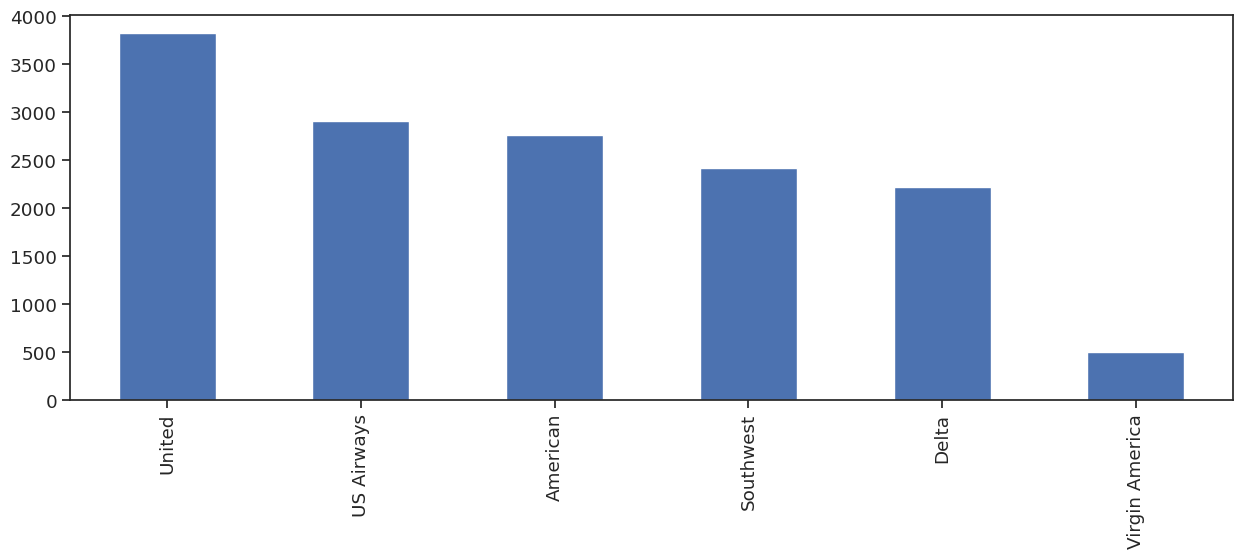

In [16]:
df.airline.value_counts().plot(kind='bar', figsize=(15,5));

## Preprocessing the data

First up, there are many columns we will not be making use of, so don't make sense to keep around. Since we will be working with an unsupervised model to classify the raw text, technically all we need is the `content` attribute. However, as discussed above, we'll keep the `author` and `date_time` ones around for context as well.

In [17]:
df = df[["airline", "text","tweet_created"]]
df.head()

airline                                               text  \
0  Virgin America                @VirginAmerica What @dhepburn said.   
1  Virgin America  @VirginAmerica plus you've added commercials t...   
2  Virgin America  @VirginAmerica I didn't today... Must mean I n...   
3  Virgin America  @VirginAmerica it's really aggressive to blast...   
4  Virgin America  @VirginAmerica and it's a really big bad thing...   

   tweet_created  
0  2/24/15 11:35  
1  2/24/15 11:15  
2  2/24/15 11:15  
3  2/24/15 11:15  
4  2/24/15 11:14

# Sentiment analysis to select negative tweets


## Fine-tuning the roBERTa model
Since we are focused on finding topics related to potential issues occurring in the space, we will first start by narrowing the dataset down to tweets expressing a negative sentiment.

To do so, we will leverage `twitter-roberta-base-sentiment`, a [roBERTa](https://huggingface.co/docs/transformers/model_doc/roberta) model trained on ~58M tweets and fine-tuned for sentiment analysis. Fine-tuning is the process of taking a pre-trained large language model (e.g. roBERTa in this case) and then tweaking it with additional training data to make it perform a second similar task (e.g. sentiment analysis).

The outputs of this analysis are as follows:
* `LABEL_0` indicates a negative sentiment 🙁
* `LABEL_1` indicates a neutral sentiment 😐
* `LABEL_2` indicates a positive sentiment 😀

**Note:** Since one of the lines of code required for sentiment analysis takes up to 40 minutes to run, we have commented this code out and will be loading the previously generated result of this cell into the next cell.

The following cell is left in for reference so participants are aware of how to conduct a sentiment analysis.

In [ ]:
# sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment")
# sentiments = sentiment_pipeline(df['text'].to_list()) # takes up to 40m - go grab a coffee if you're going to run this :)

# Because the line above takes so long, we are pickling and saving this out
#with open("sentiments.pkl", "wb") as fp:
#  pickle.dump(sentiments, fp)

# Note this has been exported to: https://storage.googleapis.com/suptech-lab-practical-data-science-public/sentiments.pkl

In [19]:
sentiments_pkl = 'https://storage.googleapis.com/suptech-lab-practical-data-science-public/sentiments.pkl'
sentiments = pickle.load(urllib.request.urlopen(sentiments_pkl))

## Evaluating the fine-tuned model

Let's now view our sentiments and confidence levels alongside the preprocessed tweets as a spot check.

In [20]:
sents = []
confs = []

for s in sentiments:
  sents.append(s['label'])
  confs.append(s['score'])

df['sentiment'] = sents
df['confidence'] = confs

df.head(10)

airline                                               text  \
0  Virgin America                @VirginAmerica What @dhepburn said.   
1  Virgin America  @VirginAmerica plus you've added commercials t...   
2  Virgin America  @VirginAmerica I didn't today... Must mean I n...   
3  Virgin America  @VirginAmerica it's really aggressive to blast...   
4  Virgin America  @VirginAmerica and it's a really big bad thing...   
5  Virgin America  @VirginAmerica seriously would pay $30 a fligh...   
6  Virgin America  @VirginAmerica yes, nearly every time I fly VX...   
7  Virgin America  @VirginAmerica Really missed a prime opportuni...   
8  Virgin America  @virginamerica Well, I didn'tÛ_but NOW I DO! :-D   
9  Virgin America  @VirginAmerica it was amazing, and arrived an ...   

   tweet_created sentiment  confidence  
0  2/24/15 11:35   LABEL_1    0.768413  
1  2/24/15 11:15   LABEL_0    0.851737  
2  2/24/15 11:15   LABEL_1    0.599276  
3  2/24/15 11:15   LABEL_0    0.920670  
4  2/24/15 11:14   LABEL_0    0.890174  
5  2/24/15 11:14   LABEL_0    0.885025  
6  2/24/15 11:13   LABEL_2    0.763109  
7  2/24/15 11:12   LABEL_0    0.773169  
8  2/24/15 11:11   LABEL_2    0.557660  
9  2/24/15 10:53   LABEL_2    0.992069

Looks reasonably good. With these sentiments in place, next we will sample from the full dataset just the tweets with neutral or negative sentiment.

In [21]:
df_neg = df.loc[(df['sentiment'] == "LABEL_0") & (df['confidence'] > 0.5)]
df_neg.shape[0]

6606

So a little more than half of our original set of ~14k+ tweets has been filtered out, which is to be expected given that we removed positive and neutral sentiment, plus low-confidence values for negative sentiment.

### Sampling the data

For the sake of this example (e.g, to work within the bounds of Colab's free tier), we'll be working with a random sample of 5000 of these tweets.

In [22]:
sample = df_neg.sample(n=5000, random_state=1337)
texts = sample.text.values.tolist()
airlines = sample.airline.values.tolist()
datetimes = sample.tweet_created.values.tolist()
sample.shape[0]

5000

We saw above that the texts of the tweets include the handle of the airline. Since our model is likely to

Now that we have our randomly sampled dataset of negative sentiment tweets, how can we extract meaning from the `text` field? There are many ways of course. Rather than going bottom up from simple techniques such as key words, n-grams, tf-idf etc., we'll jump straight into the three models:

* GSDMM
* LDA
* BERTopic

# GSDMM

The `gsdmm` [library](https://github.com/rwalk/gsdmm) implements the so-called "Gibbs Sampling algorithm for a Dirichlet Mixture Model," presented by [Yin and Wang 2014](https://storage.googleapis.com/suptech-lab-practical-data-science-public/yin-wang-2014.pdf) for the clustering of short text documents. Some advantages of this algorithm:

* It requires only an upper bound K on the number of clusters
* With good parameter selection, the model converges quickly
* Space efficient and scalable

It looks like this model will allow us to start simple and see where that gets us.

However, it does require a bit of additional pre-processing in order to use it.

### Additional data preparation (for classic models GSDMM and LDA only)

In order to be performant, both LDA and GSDMM require the removal of common words and symbols that should have no bearing on our classification ("stopword removal") and the conversion of words to their root ("lemmatization"). Finally, they need to be manually tokenized.

It is worth noting these preprocessing steps are neither required nor recommended for the advanced models we visit later on, namely, DistilBERT and BERTopic, because these massive models have many parameters to allow them to have been trained on raw text (with stopwords, conjugations, etc). If stopwords do show up in the final classification, there is an [officially recommended way to manage that](https://maartengr.github.io/BERTopic/faq.html#how-do-i-remove-stop-words) which we will cover if we need to.

In the meantime, the output of this section of the notebook will only be used for the sections on "classic" models (GSDMM and LDA).

#### Remove stopwords

Next we want to remove common words that contribute nothing to the topic of the sentence, otherwise referred to as stopwords.

In [20]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# Load english stopwords and look at the first 10
sw = stopwords.words('english')
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

We also saw above that each tweet had the twitter handle of the carrier in it. Since we are interested in the topic of the tweet and not the org that's mentioned, we want to remove this from the model.

Additionally, from prior analysis we see the words flight, customer, and service show up in nearly all the categories, so we'll remove those as well.

In [22]:
sw.append('virginamerica')
sw.append('americanair')
sw.append('united')
sw.append('southwestair')
sw.append('usairways')
sw.append('jetblue')
sw.append('flight')
sw.append('flights')
sw.append('customer')
sw.append('service')

In [23]:
# Iterate through the list, running a simple pre-processing script and removing stopwords
texts_out = []
for text in texts:
  new = ' '.join(gensim.utils.simple_preprocess(text, deacc=True, min_len=2, max_len=30)) # ignore tokens that are too short or too long
  new = gensim.parsing.preprocessing.remove_stopwords(new, sw) # remove stopwords
  texts_out.append(new)

# Look at a lemmatized version of the first tweet
texts_out[:10]

['lies lies lies worst travel experience life day clothes vaca lostluggage unprofessional pit mia',
 'horrible',
 'changed depart pm amp pm amp capt got plane find smoothie pm ass',
 'killing always delayed sandiego sf ugh',
 'cancelled flightled website says call phone number phone says check online supposed get help',
 'find funny phlairport responds worst',
 'paying fly damn plane one announcement crew let know wanna refund',
 'misplaced bag hr ago tell lost stuff americanairlines unamericanairlines',
 'get bags us said would go cincinnati even though exactly',
 'another hour gone amp sit snow seriously http co fupf uayir']

#### Lemmatize

Let’s further reduce the dimensionality of our dataset through accounting for the morphological analysis of the words. What this means is that the words “see” and its past tense “saw” will get the same value. This is why lemmatization is in many cases much better than an alternative called stemming.

In [24]:
# Only touch these parts of speech
allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]

# Load language model for english language
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Lemmatize
texts_final = []
for text in texts_out:
    doc = nlp(text) # this line takes about ~40sec for our dataset
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    texts_final.append(new_text)
texts_final[:10]

[['lie',
  'lie',
  'lie',
  'bad',
  'travel',
  'experience',
  'life',
  'day',
  'clothe',
  'lostluggage',
  'unprofessional',
  'pit',
  'mia'],
 ['horrible'],
 ['change', 'get', 'plane', 'find', 'smoothie', 'pm', 'ass'],
 ['kill', 'always', 'delay'],
 ['cancel',
  'flightle',
  'website',
  'say',
  'call',
  'phone',
  'number',
  'phone',
  'say',
  'check',
  'online',
  'suppose',
  'get',
  'help'],
 ['find', 'funny', 'phlairport', 'respond', 'bad'],
 ['pay', 'fly', 'damn', 'plane', 'announcement', 'crew', 'let', 'know'],
 ['misplace',
  'hr',
  'ago',
  'tell',
  'lose',
  'stuff',
  'americanairline',
  'unamericanairline'],
 ['get', 'bag', 'say', 'go', 'even', 'exactly'],
 ['hour', 'go', 'amp', 'sit', 'snow', 'seriously', 'http', 'uayir']]

Did the third to last one miss a stopword removal? No it didn't, because that was a plural hashtag and our goal was to only remove their handle.

In [25]:
# Look at the corresponding original tweet
texts[7]

"@AmericanAir misplaced my bag 36 hr ago and can't tell me where it is. I've lost $1000 of stuff :( #AmericanAirlines #unamericanairlines"

#### Tokenize

In [27]:
# Turn the list of previously lemmatized and stopword-stripped strings into a list of numeric tokens
id2word = Dictionary(texts_final)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts_final]

# Look at a tokenized version of the first tweet
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 3),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1)]

In [ ]:
# Swap words back in for IDs to double check the first tweet
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

[[('bad', 1),
  ('clothe', 1),
  ('day', 1),
  ('experience', 1),
  ('lie', 3),
  ('life', 1),
  ('lostluggage', 1),
  ('mia', 1),
  ('pit', 1),
  ('travel', 1),
  ('unprofessional', 1)]]

In [ ]:
# Cleaning up
# For the sake of this example, to keep resource needs (RAM, CPU/GPU) light, we'll remove some
# variables that aren't used after this point
# NOTE: if you are experimenting with this notebook, please comment these lines out
del dataset # original full tweet dataset
del sentiments # all sentiments - filtering has been done
del df # original dataframe – already filtered it
del df_neg # negative dataframe – already grabbed `texts` from this
del nlp # model for lemmatization
del texts_out # lemmatized texts
del text # was a temp variable above

### Training the model

With preprocessing complete, we can get to the training of the model. A short summary is as follows.

A `MovieGroupProcess` is a conceptual model to describe Gibbs sampling algorithm for a Dirichlet Mixture Model for the clustering short text documents. The term was introduced by [Yin and Wang 2014](https://storage.googleapis.com/suptech-lab-practical-data-science-public/yin-wang-2014.pdf) using an analogy of a professor splitting students in a film class into groups, which can be read in the paper above.

Here, we've adapted the narrative to our scenario:

* Imagine a data scientist's GSMM model, "Mo", is "looking" at a set of tweets.
* At the beginning of the process, Mo randomly assigns each tweet to one of the `K` categories.
* Before classification begins, Mo analyzes the tweets to extract a list of each tweet's "favorite" (most frequent) words.
* Mo then reviews the list of tweets `n_iters` times.
* When each tweet, Mo must assign them to a new category satisfying either:
  1. The new category has more tweets than the current category.
  2. The new category has tweets with similar lists of favorite words.

Additional parameters help to understand how frequently "Mo" chooses one of these options:

* `alpha` controls the probability that a tweet will be assigned to a category that is currently empty. When `alpha` is 0, no tweet will join an empty category.
* `beta` controls Mo's likelihood to assign a tweet to a category with other tweets with similar words. A low `beta` means that tweets are more likely to be placed with tweets with similar words. A high `beta` means the model is less concerned with affinity and are more influenced by the popularity of a category.

Generally, we want to select these 4 parameters such that we see convergence around less than `K` groups, and transferring across groups levels out. (i.e., if not, we may be overly constraining the max size, allowing too many tweets to choose empty groups, or not iterating enough times)

In [ ]:
# Set params for the GSDMM algorithm
mgp = MovieGroupProcess(K=20, alpha=0.1, beta=0.08, n_iters=120)

In [ ]:
vocab = set(x for text in corpus for x in text)
n_terms = len(vocab)
n_docs = len(corpus)

In [ ]:
# Fit the model on the data given the chosen seeds (~8min runtime)
# Returns a list of length len(doc) of cluster labels for each document
y = mgp.fit(corpus, n_terms)

In stage 0: transferred 4257 clusters with 20 clusters populated
In stage 1: transferred 2781 clusters with 20 clusters populated
In stage 2: transferred 2153 clusters with 20 clusters populated
In stage 3: transferred 1852 clusters with 20 clusters populated
In stage 4: transferred 1695 clusters with 20 clusters populated
In stage 5: transferred 1555 clusters with 20 clusters populated
In stage 6: transferred 1462 clusters with 20 clusters populated
In stage 7: transferred 1439 clusters with 20 clusters populated
In stage 8: transferred 1403 clusters with 20 clusters populated
In stage 9: transferred 1293 clusters with 20 clusters populated
In stage 10: transferred 1267 clusters with 20 clusters populated
In stage 11: transferred 1260 clusters with 20 clusters populated
In stage 12: transferred 1181 clusters with 20 clusters populated
In stage 13: transferred 1232 clusters with 20 clusters populated
In stage 14: transferred 1188 clusters with 20 clusters populated
In stage 15: transfe

A couple of observations:

* **Transfers are generally decreasing over time** which is a positive sign, since it indicates tweets are finding their fits within categories then staying put. In an ideal world we might see this drop to 0. However it is almost certain there are tweets in this dataset that have an absolutely unique subject (thus wouldn't match any other tweet in the dataset). So those will keep bouncing around no matter how many rounds we run.

* **Clusters are not maxed out** at 20 (we only see 16 that have been populated), which indicates we've set a healthy limit to the number of clusters that is not artificially constraining what this model could identify.

Of course additional training in a dataset like this could be interesting, particularly since the overall trend of "transfers" was still decreasing. But given the time and resource constraints within the class, we'll cap it at 120 for now and move to evaluation.

## Evaluating the model

<Axes: >

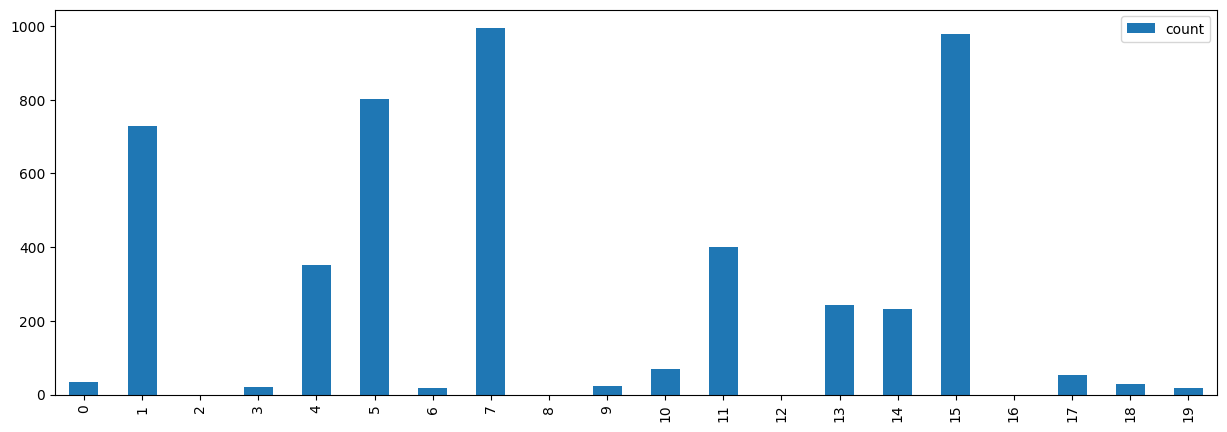

In [ ]:
# Visualize tweet count per category
pd.DataFrame({"count":mgp.cluster_doc_count}).plot(kind='bar', figsize=(15,5))

In [ ]:
word_frequencies = []
num_words = 10

for distro in mgp.cluster_word_distribution:
  if len(distro) > 0:
    topic = sorted(distro.items(), key=lambda k: k[1], reverse=True)[:num_words]
    dfm = pd.DataFrame(topic)
    dfm = dfm.rename(columns={0: 'Word', 1: 'Freq'})
    word_frequencies.append(dfm)
  else:
    word_frequencies.append(pd.DataFrame())

# Swap words back in for IDs to see top words for the third category
[(id2word[w[0]], f) for w,f in zip(word_frequencies[3].Word, word_frequencies[3].Freq)]

[('get', 5),
 ('contact', 5),
 ('issue', 5),
 ('ever', 4),
 ('good', 4),
 ('system', 4),
 ('airline', 3),
 ('talk', 3),
 ('resolution', 3),
 ('aqjn', 3)]

In [ ]:
# Show the top 10 words in term frequency for top cluster
for i, wf in enumerate(word_frequencies):
    print('Cluster %s:'%(i))
    if wf.shape[0] > 0:
      print("%s" % ([(id2word[w[0]], f) for w,f in zip(wf.Word, wf.Freq)]))
    else:
      print('[]')
    print(' — — — — — — — — — ')

Cluster 0:
[('feel', 6), ('new', 5), ('pay', 4), ('seat', 4), ('point', 4), ('run', 4), ('go', 4), ('amp', 4), ('even', 3), ('policy', 3)]
 — — — — — — — — — 
Cluster 1:
[('get', 116), ('book', 81), ('try', 65), ('still', 61), ('phone', 58), ('help', 57), ('email', 54), ('time', 53), ('check', 48), ('call', 48)]
 — — — — — — — — — 
Cluster 2:
[]
 — — — — — — — — — 
Cluster 3:
[('get', 5), ('contact', 5), ('issue', 5), ('ever', 4), ('good', 4), ('system', 4), ('airline', 3), ('talk', 3), ('resolution', 3), ('aqjn', 3)]
 — — — — — — — — — 
Cluster 4:
[('bag', 58), ('lose', 56), ('get', 48), ('still', 45), ('hour', 29), ('help', 27), ('give', 24), ('plane', 23), ('go', 23), ('luggage', 23)]
 — — — — — — — — — 
Cluster 5:
[('delay', 196), ('plane', 162), ('hour', 161), ('get', 108), ('sit', 104), ('wait', 91), ('miss', 80), ('gate', 74), ('late', 66), ('time', 64)]
 — — — — — — — — — 
Cluster 6:
[('death', 7), ('know', 5), ('cause', 5), ('second', 5), ('lead', 5), ('suicide', 5), ('teen', 

Interesting. It looks like several clusters have themes. 

For example, depending on your random seed, the first cluster appears to be related to cancelations and extended delays.

But you may also see clusters related to:

* Delayed responses to complaints and emails
* Booking-related queries
* Observations about crimes, safety, and harm
* Complaints related to luggage
* In-flight services

Let's dive into the first one to check it out.

In [ ]:
# First 10 of the original tweets falling into Cluster 0
[tweet for i,tweet in enumerate(texts) if y[i]==0][:10]

["@united is so cheap they couldn't afford to run the AC on #UA1510. They took pressure cooker to a new level. #Cheap #WorstAirline",
 "@USAirways $75 for that uncertainty? I know u run an account; u don't create policy. But it's an undue penalty for a job req'ing flexibility",
 '@USAirways 2 days in a row, not buying it. I suggest you review your policy w respect to unaccompanied minors, should have had a seat on Sun',
 "@USAirways if you could have ran your USExpress/PSA worth a damn I wouldn't be stuck in horrible CLT now.",
 '@united why de-ice before taxing? Maybe it #makestoomuchsense ? #shouldhaveflowndelta #unitedsucks @Delta @SouthwestAir @AmericanAir',
 "@united I'm fully aware, it's just that your rules are harsh toward the client. Especially since you're going to resell my seat for more $.",
 "@SouthwestAir missing out on over 6,000 points in one account. They're now spread over four assuming I create accounts for them",
 '@USAirways your new seat assignment service is an e

## Testing on new data

Now let's try our model on a brand new tweet! Note that we cannot pass the raw text directly to the model, but have to follow the same steps we did for the training: preprocessing, stopword removal, lemmatization, and tokenization.

Let's try it out:

In [ ]:
new_tweet = "@united hey your wifi connectivity stinks! Can't even watch my movie on the screen either..."

# ignore tokens that are too short or too long
new_tweet = ' '.join(gensim.utils.simple_preprocess(new_tweet, deacc=True, min_len=2, max_len=30))

# remove stopwords
new_tweet = gensim.parsing.preprocessing.remove_stopwords(new_tweet, sw)

# lemmatize
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
doc = nlp(new_tweet)
new_tweet_arr = []
for token in doc:
    if token.pos_ in allowed_postags:
        new_tweet_arr.append(token.lemma_)

# tokenize
new_tweet = id2word.doc2bow(new_tweet_arr)

del nlp

mgp.choose_best_label(new_tweet)

(10, 0.9544157329807625)

Indeed, for a tweet related to wifi connectivity and in-flight entertainment, our model drops it in the appropriate cluster with very high confidence.

It appears to do a decent job, but picks up on some things we'd prefer it not to. What do you see here?

Let's try another model to see if we can do better.

# LDA modeling

Let's now turn to another classic approach - LDA, Latent Dirichlet Allocation. We will not review the theory or the inner workings of this algorithm here. The key difference vs. GSDMM is that each text (document) is considered to be a composition of topics rather than one. We don't cluster documents into topics, but instead discover abstract topics that are represented in a document corpus. For each document, we get the probability distribution over these topics.

Let's imagine we have discovered three topics: sports, data science, competition.

A document that is about data science competition might have the following distribution: *sports: 0.05, data science: 0.5, competition: 0.045*.

A document that talks about world championship in cricket might have the following distribution instead: *sports: 0.54, data science: 0.01, competition: 0.45*.

There seem to be many implementations of the LDA algorithm, and some of them result in significantly worse results. So it is worth revisiting if we don't get solid results here.

## Training the model

We first train the model using the following parameters described further in the [documentation](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel):

*	`corpus` is the list of the tweets represented as numbers, i.e., the output of the embedding step of the preprocessing
*	`id2word` is the mapping from embeddings back to words, used for human-readable output
*	`num_topics` is the number of topics we’re aiming for – set to 20 here since we saw 16-20 topics organically showing up in GSDMM earlier
*	`random_state` is a parameter used for reproducibility (i.e. so my model and your model get the same results given the same data)
*	`chunksize` is the number of documents to consider at each step of the training process
*	`alpha` is a way of capturing any a priori belief we might have about the distribution of topics. Here we could in theory use our GSDMM distribution that we visualized earlier, but instead we’ll set it to auto to let LDA operate independently
*	`per_word_topics` is the ability for the model to also show the distribution of topics for each given word in addition to each tweet, which costs extra training time and we do not need here. So we set to False


In [ ]:
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=20,
                   random_state=1337,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=False)

doc_lda = lda_model[corpus]

for i in lda_model.print_topics():
  print(i)

(0, '0.230*"bag" + 0.220*"still" + 0.157*"lose" + 0.131*"late" + 0.045*"site" + 0.044*"flightr" + 0.012*"mechanical" + 0.002*"resolution" + 0.000*"help" + 0.000*"amp"')
(1, '0.158*"sit" + 0.128*"way" + 0.097*"staff" + 0.091*"home" + 0.068*"connect" + 0.063*"employee" + 0.058*"lack" + 0.032*"loyal" + 0.028*"dfw" + 0.022*"force"')
(2, '0.000*"earning" + 0.000*"cease" + 0.000*"svc" + 0.000*"yelled" + 0.000*"narrow" + 0.000*"bloated" + 0.000*"loading" + 0.000*"hassle" + 0.000*"rarely" + 0.000*"lnde"')
(3, '0.206*"day" + 0.128*"min" + 0.114*"leave" + 0.098*"last" + 0.075*"stick" + 0.065*"early" + 0.051*"arrive" + 0.024*"do" + 0.014*"get" + 0.011*"plane"')
(4, '0.161*"cancel" + 0.108*"flightle" + 0.079*"guy" + 0.062*"get" + 0.058*"due" + 0.055*"week" + 0.049*"fail" + 0.044*"amp" + 0.040*"airport" + 0.034*"response"')
(5, '0.196*"hold" + 0.108*"say" + 0.098*"book" + 0.098*"hour" + 0.087*"even" + 0.082*"make" + 0.072*"problem" + 0.061*"use" + 0.020*"booking" + 0.017*"also"')
(6, '0.161*"help" 

## Evaluating the model

In the [PyLDAVis](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know) chart below:

* Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
* Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
* Red bars give the estimated number of times a given term was generated by a given topic.
* The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.

For example if you click the bubble for topic 8, you can see (a) there are about 400 mentions of the word "cancel" in the tweets in this cluster, while this term is used about 1,200 times in the overall dataset, and (b) the word "flight" is used third most in this topic while not at all in other topics.


In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
p

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.372745 -0.224572       1        1  8.612499
4     -0.421864 -0.052192       2        1  7.850023
17    -0.017180 -0.329584       3        1  7.383443
6     -0.142880 -0.415157       4        1  7.144655
11     0.128076  0.441011       5        1  6.884107
5     -0.194377  0.352151       6        1  6.867814
16    -0.349396  0.266619       7        1  6.618888
10    -0.228334 -0.233290       8        1  6.136097
7      0.147165 -0.381441       9        1  5.249509
8      0.422989 -0.084052      10        1  4.948051
0      0.321551 -0.281405      11        1  4.747623
18     0.379517  0.206439      12        1  4.658014
13    -0.315303  0.125504      13        1  4.411356
3     -0.135095  0.012018      14        1  4.274318
9     -0.023836  0.323420      15        1  4.066672
1      0.177582  0.263789      16        1  3.273346
12     0.139546 -0.121012      17        1  2.389079
15     0.269190  0.009816      18        1  2.178435
14     0.156722  0.101223      19        1  1.949783
2      0.058672  0.020713      20        1  0.356288, topic_info=        Term         Freq        Total Category  logprob  loglift
22      call   712.000000   712.000000  Default  30.0000  30.0000
20     delay   709.000000   709.000000  Default  29.0000  29.0000
15       get  1295.000000  1295.000000  Default  28.0000  28.0000
56      hour   924.000000   924.000000  Default  27.0000  27.0000
91      time   608.000000   608.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
25  flightle     0.030805   330.626221  Topic20  -8.4129  -3.6439
26      help     0.030805   538.002925  Topic20  -8.4129  -4.1308
27    number     0.030805   152.992535  Topic20  -8.4129  -2.8733
28    online     0.030805    81.106767  Topic20  -8.4129  -2.2387
29     phone     0.030805   362.692935  Topic20  -8.4129  -3.7365

[887 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
391       2  0.969493          aa
154       9  0.979776        able
190       1  0.887964  acceptable
295      10  0.915984      access
176       6  0.970806     account
...     ...       ...         ...
344      19  0.960783       worst
249       1  0.986077       wrong
166      10  0.982565        year
67        4  0.980998   yesterday
389       7  0.985007         yet

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 5, 18, 7, 12, 6, 17, 11, 8, 9, 1, 19, 14, 4, 10, 2, 13, 16, 15, 3])

This is a good start, but our model will be better if the words in a topic are similar, so we will use topic coherence to evaluate our model. Topic coherence evaluates a single topic by measuring the degree of semantic similarity between high scoring words in the topic. A good model will generate topics with high topic coherence scores.

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_final, corpus=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40393239706985035


## LDA Mallet

Fortunately, there is an LDA model that provides better quality of topics called the LDA Mallet Model.

The [MALLET](https://mimno.github.io/Mallet/topics) ("machine learning for language toolkit") topic model package is a Java package that includes an extremely fast and highly scalable implementation of Gibbs sampling, efficient methods for document-topic hyperparameter optimization, and tools for inferring topics for new documents given trained models.

The [little-mallet-wrapper](https://github.com/maria-antoniak/little-mallet-wrapper) package is python wrapper for that function.

Together, these give us the power to have clusters with coherent subjects.

In [ ]:
lmw.print_dataset_stats(texts)

Number of Documents: 5000
Mean Number of Words per Document: 20.0
Vocabulary Size: 14268


In [ ]:
# Specify metaparams
num_topics = 20
output_directory_path = ''

# Preprocess the text
texts_preprocessed = []
for text in texts:
  texts_preprocessed.append(lmw.process_string(text, stop_words=sw))

# Train the model
topic_keys, topic_distributions = lmw.quick_train_topic_model(mallet_path,
  output_directory_path,
  num_topics,
  texts_preprocessed)

# Review the results
for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

Importing data...
Complete
Training topic model...
Complete
0 	 bag lost luggage baggage bags amp checked airport still check
1 	 miss connection missed delayed please help delay connecting stuck thanks
2 	 time thanks disappointed every right last day really trip airline
3 	 hotel food give http airport say night voucher money even
4 	 worst ever airline never experience fly guys flying airlines horrible
5 	 problems booking reflight weather time cause flightd make death usairwaysfail
6 	 NUM plane gate waiting delay sitting hour delayed stuck crew
7 	 email response never still got sent nothing yet also received
8 	 http wifi check app working site amp book tried trouble
9 	 would like sure one well sucks anything said http love
10 	 NUM ticket miles credit change would use charge card fee
11 	 boarding attendant pass amp early check member also pre refused
12 	 like customers bad want think care way really http good
13 	 call back get phone system called line help got wait
14 	 seat

Intuitively, we can see already that this model is producing topics with more coherent keywords:

* One is clearly about lost bags
* One is clearly about missed flights
* One is clearly about feeling defeated
* One is clearly about compensation
* etc

Let's take a deep dive into the first one in the list produced above.

In [ ]:
for p, d in lmw.get_top_docs(texts, topic_distributions, topic_index=0, n=10):
    print(round(p, 4), d)
    print()

0.8606 @united @delta lost my luggage from ATL to  hdn luggage in denver and said @united will deliver my luggage to HDN airport claim# hdndl11785

0.7996 @USAirways @AuroraBIZ check your bag, @PHLAirport bag handlers broke into my suitcase and stole my camera, bag was returned in a trash bag

0.7386 @united my golf bag didn't have a top cover + staffers said they couldn't check without a type of cover or wrap. Forced to leave the bag...

0.7023 @united Holiday of a lifetime to New York ruined because you lost my luggage and have failed to find it since Sunday! #wontflyagainwithyou

0.6801 @SouthwestAir LOST Kay Chapman Designs art-luggage for important show. Won't help locate it. Terrible customer service.

0.6428 @united @el_ingeniero don't check your baggage if you don't have to.  They will lose it!

0.6329 @united iah to charlotte. Baggage claim rep latrice h. #customerservice non existent, Ignored customer then inappropriately touched customer

0.6088 @SouthwestAir what to do when

Indeed, this is about a coherent topic.

So on the surface our Mallet-enhanced LDA model with increased topic coherence appears to be an even more useful model than the initial LDA one.

We will leave deeper application and evaluation of this model as an independent exercise, since we want to cover one more advanced topic.

# Advanced model

## Tokenization (via DistilBERT embeddings)

A key idea for machine learning is that of representations. Most algorithms can only work with numbers, so whatever we're dealing with - words, texts, images - we should represent with numbers. As we established in previous lessons, these numerical representations are called embeddings and the process of converting text to embeddings is called tokenization.

Whereas in the previous GSDMM and LDA models, we used extremely simple pairs of numbers to represent each word’s position in an index and its frequency within a tweet, there are now much more robust ways to handle this.

After all, we are focusing on texts here, and of course texts can represent many different things that go beyond how many times it shows up in a document. So we also need many numbers. This is where BERT models covered earlier come in. In particular, [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) uses millions of parameters to represents each word as 768 features (see [here](https://stackoverflow.com/a/71472362) for some details).

For the purpose of this lesson, we will not worry about where these embeddings come from, other than the fact we can produce them with the SentenceTransformer library. We will load a pretrained model and use it to encode our texts.

In [23]:
model = SentenceTransformer('stsb-distilbert-base')

Airline handles appear most frequently in the text, yet we don't want them to influence our embeddings, visualization, and subsequent modeling. So here we first create a copy of the sampled tweets data without these handles. Note that here we only remove these handles and not the full set of stopwords because the BERTopic model we use is robust to stopwords.

In [24]:
texts_bertopic = []
for text in texts:
  text = text.replace("@AmericanAir","")
  text = text.replace("@JetBlue","")
  text = text.replace("@SouthwestAir","")
  text = text.replace("@VirginAmerica","")
  text = text.replace("@USAirways","")
  text = text.replace("@united","")
  text = texts_bertopic.append(text)

In [25]:
embeddings = model.encode(texts_bertopic) # Note: this takes ~300sec when on CPU tier (~15sec with GPU)

### Dimensionality Reduction

768 numbers for each text is actually less meaningful to a normal person than a text, so how does this help? We can use some magic to reduce these 768 numbers to 2. These magic is called `t-SNE` and it's one of several dimensionality reduction techniques (for example `PCA` or `UMAP`). It tries to preserve the relative positions of points in a multidimensional space while mapping it to fewer dimensions. With 2 dimensions, we can actually plot these points (texts) on a chart! Let's do it!

Because these embeddings are extremely high-dimensional (768 dimensions) we need to reduce the dimensions in order to visualize them (e.g. to 2 or 3 dimensions). Here we use t-SNE to reduce to 2 dimensions, then visualize.

In [26]:
out = sklearn.manifold.TSNE(n_components=2).fit_transform(embeddings) # Note: this takes up to ~60sec

### Visualization with bokeh

Bokeh is a nice tool that allows us to create interactive charts. We'll use it to create a scatter plot where each text is placed according to the *meaning dimension*. Additionally, we're color each dot to indicate which category it comes from. We can hover over the chart and see the text/category associated with each dot.

In [27]:
clrs = random.sample(Turbo256, len(set(airlines)), )
color_map = bmo.CategoricalColorMapper(factors=list(set(airlines)), palette=clrs)

In [28]:
list_x = out[:,0]
list_y = out[:,1]
content = texts_bertopic

source = ColumnDataSource(data=dict(x=list_x, y=list_y, content=content, airline=airlines, datetime=datetimes))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('content', '@content'),
    ('airline', '@airline'),
    ('datetime', '@datetime')
])

p = figure(width=1000, height=600, tools=[hover], title="First Look at the Data")
p.circle('x', 'y', size=10, source=source, fill_color=transform('airline', color_map),)
bpl.show(p)

Looks interesting! If you hover over the distinct clusters on the chart, you should be able to recognize common topics. Some of these topics are related to a single category, some of them are shared across categories. What topics can you find in the chart?

For example, see if you can find the cluster that appears to relate to with issues in-flight wifi.

Looking at the chart above, we can get a sense for some of the topics in our corpus, but it doesn't solve our problem yet. It would require lots of time to review the chart in detail, find clusters, and label them. How can we automate this process?

## Automatic clustering (BERTopic)
BERTopic is one of the methods to achieve that. It depends on sentence embeddings and clustering algorithms, as well as dimensionality reduction to produce clusters of documents (topics). Let's if we can get some good insights with this approach.

### Training the model

In [40]:
# takes up to ~60sec the first time around (or up to 300sec if using CPU instead of GPU)
# UMAP is used for consistency between runs: https://maartengr.github.io/BERTopic/faq.html#why-are-the-results-not-consistent-between-runs
# UMAP default params copied from: https://github.com/MaartenGr/BERTopic/blob/362ccc6b9acbf9e15a24edcbcfdeb81a2dd007ff/bertopic/_bertopic.py#L229C5-L229C5
# this is initially downloading the specified model,
# then fine-tuning the model

umap = UMAP(n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            low_memory=False,
            random_state=1337)
model = BERTopic(language="multilingual", umap_model=umap)
topics, probs = model.fit_transform(content)

In [41]:
len(topics), len(set(topics))

(5000, 59)

We've run the algorithm on our 5000 texts sample, and it identified nearly 60 topics in this corpus. Let's see if we can learn something more about those topics!

In [42]:
model.get_topic_freq().head(15)

Topic  Count
0      -1   2539
2       0    457
5       1    262
21      2    106
4       3     87
32      4     72
29      5     68
18      6     61
20      7     55
22      8     52
15      9     51
3      10     49
39     11     45
1      12     43
25     13     40

Wow, there's quite a lot of outliers here, represented by topic -1, almost half of the dataset!

Let's take a look at the key words defining the other topics here.

In [43]:
topic_words = ['-1: outlier']
for i in range(len(set(topics))-1):
  tpc = model.get_topic(i)[:7]
  words = [x[0] for x in tpc]
  tw = ' '.join([str(i) + ':'] + words)
  topic_words.append(tw)

topic_words

['-1: outlier',
 '0: cancelled flight flightled flighted my help to',
 '1: bag luggage my bags baggage lost where',
 '2: call phone up hung me on hold',
 '3: refund 200 flight cost change for cancelled',
 '4: hold minutes on hours been for over',
 '5: seat seats extra my paid together select',
 '6: wifi oscars tv entertainment inflight slow no',
 '7: reservation reservations hold on phone through online',
 '8: suck you shit sucks fuck guys hate',
 '9: delays delay we delayed hour wait times',
 '10: customers customer loyal your you service experience',
 '11: credit refund card bank charge receipt charged',
 '12: http co lies you killing grown yourself',
 '13: agent hold agents an call on phone',
 '14: delayed flight late delay hour scheduled crash',
 '15: united ticket never may bye counter portland',
 '16: worst airline ever the flying had far',
 '17: site website check your down online safari',
 '18: she her serving drinks drunk karen rep',
 '19: tweet twitter tweets you respond me a

Let's take a deep dive look at one of the topics from this dataset.

Since we visually noticed something like the "wifi entertainment inflight slow no working for" cluster earlier in the notebook, let's dive in to that one to start.

In [45]:
topic_id = 6
model.get_topic(topic_id)

[('wifi', 0.14834448913177523),
 ('oscars', 0.03742322632595787),
 ('tv', 0.028615060047170477),
 ('entertainment', 0.02661790543570479),
 ('inflight', 0.02574684471291183),
 ('slow', 0.022950440339123017),
 ('no', 0.021528945474325708),
 ('working', 0.019040116751890684),
 ('the', 0.01743483621199609),
 ('abc', 0.017371678846350182)]

What we typically get with topic modelling is key words associated with each topic. In the case above, we can see key words clearly associated with a given topic. Let's take a look at some texts associated with this topic to confirm our intuition.

In [46]:
ex_ind = [i for i, x in enumerate(topics) if x == topic_id]
ex_txt = [x for i, x in enumerate(texts) if i in ex_ind]
ex_a = [x for i, x in enumerate(airlines) if i in ex_ind]
ex_dt = [x for i, x in enumerate(datetimes) if i in ex_ind]
for t,a,dt in zip(ex_txt[:10], ex_a[:10], ex_dt[:10]): print("%s (@%s, %s)" % (t, a, dt))

@united, UA1641 EWR-MCO 17 Feb wifi never connected but allowed me to purchase access twice &amp; charged me. Who do I need to file claim with? (@United, 2/18/15 16:23)
@united I have tried and you have failed. Still no wifi ever, last row in the middle and I fly every week. Thanks for nothing. (@United, 2/22/15 12:36)
@SouthwestAir I can't begin to tell you how slow my plane's wifi is. I can't even pull up an email.  What am i paying $8 for?? (@Southwest, 2/19/15 19:30)
@united now 1558 from IAH to EWR has broken entertainment system and no WiFi despite info on app: http://t.co/FY6f9rZB9k (@United, 2/20/15 8:22)
@jetblue well, we're on our way now, but more than half my tv channels are just static. _Ù÷Ó (@Delta, 2/19/15 16:53)
@SouthwestAir I paid for inflight wifi only for it not to work. Download speed was 0.21mbps &amp; I ended up watching the free TV instead. (@Southwest, 2/19/15 7:57)
@united is so cheap they couldn't afford to run the AC on #UA1510. They took pressure cooker to 

Indeed, most of these texts talk about the same topic, and also happen to cover across multiple airlines' accounts! Looks like the model is onto something!


### Visualization with Bokeh

What if we overlay the topics discovered here with our initial scatter plot? Let's try it! Now, instead of airlines, we will color the dots according to the topic assigned by BERTopic algorithm.

In [47]:
# Set fill color map
clrs = random.sample(Turbo256, len(set(topics))) # random colors for fill
clrs[0] = "#00000000" # transparent fill for unclassified
color_map = bmo.CategoricalColorMapper(factors=topic_words, palette=clrs)

# Set line color map
lns = ["#cccccc"] * len(clrs) # grey outline for all circles
lns[0] = "#00000000" # transparent outline for unclassified
line_map = bmo.CategoricalColorMapper(factors=topic_words, palette=lns)

In [48]:
exp_topics = [topic_words[x+1] for x in topics]

In [62]:
# Using the same list_x, list_y, and content from above
source = ColumnDataSource(data=dict(x=list_x, y=list_y, content=content, topic=exp_topics))
hover = HoverTool(tooltips=[
    ("topic", "@topic"),
    ('content', '@content')
])

p = figure(width=1000, height=600, tools=[hover])
p.title.text = 'Click on legend entries to hide the corresponding circles'
p.circle('x', 'y', size=8, source=source,
         fill_color=transform('topic', color_map),
         line_color=transform('topic', line_map)
)

p.legend.location = "top_left"
p.legend.title = "Topic"
p.legend.click_policy="hide"

bpl.show(p)

In this visual, the topics are clustered together - which makes sense, because the method for creating visual and topics is consistent. Interestingly, when looking at clusters of outliers that are located near each other in the chart, we can see common theme - I wonder why these were tagged as outliers? What other common themes do you see?

### Evaluation, topic condensation, and testing on new data

There are very many topics and some of them may even seem redundant. Thankfully, the BERTopic library comes with a mechanism for visualizing the "nearness" of topics, in a similar manner to what LDAvis did above for the LDA model.

This can be used to inform relabeling – for example we see  many topics relating to delays and cancelations, many topics to do with support, two topics that relate to baggage, etc.

Apparently we could bring our count of topics from nearly 60 down to around 15, which would be consistent with the GSDMM and LDA approaches.

In [63]:
model.visualize_topics()

Finally, let's try predicting a new topic. We can imagine a tweet that is about some luggage going missing, which based on the chart above we would expect to fall under topics 1, 39, or 55 (the "baggage" supercluster).

In [64]:
new_tweet = "@united holy cow I'm so upset that my luggage is yet again missing. Third time you've lost my bags this month!"
model.transform([new_tweet])

([1], array([0.79990771]))

Indeed, our model predicts with high confidence that the tweet should be placed into the appropriate group.

In production, such a model output could then automatically raise an alert with the team responsible for that type of complaint to respond to the tweet and address the issue.

Pretty powerful stuff!

# Further Research

Below you can find links to some additional materials, research and tools related to topic modeling.

Top2Vec
- https://github.com/ddangelov/Top2Vec

Topic modeling in embedding spaces
- https://www.mitpressjournals.org/doi/full/10.1162/tacl_a_00325

The Dynamic Embedded Topic Model
- evolution of topics over time
- https://arxiv.org/pdf/1907.05545.pdf

TopicScan (NMF)
- https://github.com/derekgreene/topicscan

Topic model evaluation
- https://www.aclweb.org/anthology/E14-1056.pdf

Improving Neural Topic Models using Knowledge Distillation
- https://www.aclweb.org/anthology/2020.emnlp-main.137.pdf
- https://twitter.com/miserlis_/status/1305893876767612929
- https://github.com/ahoho/kd-topic-models

Neural Topic Modeling by Incorporating Document Relationship Graph
- Applying Graph NN to topic modeling
- https://www.aclweb.org/anthology/2020.emnlp-main.310.pdf

Weakly-Supervised Aspect-Based Sentiment Analysis via Joint Aspect-Sentiment Topic Embedding
- unsupervised combination of topic modeling and and aspect-based sentiment tagging
- https://github.com/teapot123/JASen  
- https://arxiv.org/pdf/2010.06705v1.pdf

Tired of Topic Models? Clusters of Pretrained Word Embeddings Make for Fast and Good Topics too!
- Similar to top2vec?
- https://arxiv.org/pdf/2004.14914v2.pdf
- https://github.com/adalmia96/Cluster-Analysis

Cross-lingual Contextualized Topic Models with Zero-shot Learning
- model learns topics in one language and predicts them for documents in another language
- https://arxiv.org/pdf/2004.07737v1.pdf

Pre-training is a Hot Topic: Contextualized Document Embeddings Improve Topic Coherence
- Another variation on neural topic modeling
- https://arxiv.org/pdf/2004.03974v1.pdf

Familia: A Configurable Topic Modeling Framework for Industrial Text Engineering
- Baidu’s framework for topic modeling and overview of use cases
- https://arxiv.org/pdf/1808.03733v2.pdf

Aspect Sentiment Model for Micro Reviews
- https://arxiv.org/pdf/1806.05499v1.pdf

Studying the History of Ideas Using Topic Models
- nice application of topic models by jurafsky, manning - get inspiration
- https://web.stanford.edu/~jurafsky/hallemnlp08.pdf

CoRel: Seed-Guided Topical Taxonomy Construction by Concept Learning and Relation Transferring
- User inputs a partial taxonomy, and CoRel extracts a more complete topical taxonomy based on user-interested aspect and relation, with each node represented by a cluster of words.
- https://arxiv.org/pdf/2010.06714.pdf
